# Working with Text

> **Author**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)


**Prerequisites**

- [Visualization Rules](visualization_rules.ipynb)  
- [Regression](regression.ipynb)  
- [Classification](classification.ipynb)  
- [Maps](maps.ipynb)  


**Outcomes**

- Use text as features for classification  
- Understand latent topic analysis  
- Use folium to create an interactive map  
- Request and combine json data from a web server  

## Outline

- [Working with Text](#Working-with-Text)  
  - [Introduction](#Introduction)  
  - [Avalanches](#Avalanches)  
  - [Predicting Incidents from Text](#Predicting-Incidents-from-Text)  
  - [Unsupervised Learning](#Unsupervised-Learning)  
  - [Exercises](#Exercises)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction

Many data sources contain both numerical data and text.

We can use text to create features for any of the prediction methods
that we have discussed.

Doing so requires encoding text into some numerical representation.

A good encoding preserves the meaning of the original text, while
keeping dimensionality manageable.

In this lecture, we will learn how to work with text through an
application — predicting fatalities from avalanche
forecasts.

## Avalanches

Snow avalanches are a hazard in the mountains. Avalanches can be
partially predicted based on snow conditions, weather, and
terrain. [Avalanche Canada](https://www.avalanche.ca/map) produces
daily avalanche forecasts for various Canadian mountainous regions.
These forecasts consist of 1-5 ratings for each of three
elevation bands, as well as textual descriptions of recent avalanche
observations, snowpack, and weather. Avalanche Canada also
maintains a list of [fatal avalanche incidents](https://www.avalanche.ca/incidents/) . In this lecture, we will
attempt to predict fatal incidents from the text of avalanche
forecasts. Since fatal incidents are rare, this prediction task will
be quite difficult.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

### Data

Avalanche Canada has an unstable json api. The api seems to be largely
tailored to displaying the information on various Avalanche Canada
websites, which does not make it easy to obtain large amounts of
data. Nonetheless, getting information from the API is easier than
scraping the website. Generally, whenever you’re considering scraping
a website, you should first check whether the site has an API available.

#### Incident Data

In [3]:
# Get data on avalanche forecasts and incidents from Avalanche Canada
# Avalanche Canada has an unstable public api
# https://github.com/avalanche-canada/ac-web
# Since API might change, this code might break
import json
import os
import urllib.request
import pandas as pd
import time
import requests
import io
import zipfile
import warnings


# Incidents
url = "http://incidents.avalanche.ca/public/incidents/?format=json"
req = urllib.request.Request(url)
with urllib.request.urlopen(req) as response:
    result = json.loads(response.read().decode('utf-8'))
incident_list = result["results"]
while (result["next"] != None):
    req = urllib.request.Request(result["next"])
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    incident_list = incident_list + result["results"]
incidents_brief = pd.DataFrame.from_dict(incident_list,orient="columns")
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
incidents_brief

,date,group_activity,id,location,location_province,num_fatal,num_injured,num_involved
0,2020-03-14,Snowshoeing,dd556e1a-90f6-46a9-a31b-02508504f2d7,Brunswick Mountain,BC,1,0.0,1.0
1,2020-02-19,Skiing,9fcf2d9f-964b-4329-b3d2-54a7f1c6c9ee,Joe Louis aux Mines Madeleine,QC,1,1.0,2.0
2,2020-02-13,Snowmobiling,3c2ecc57-f40c-4ae5-afeb-a2abd624d8a8,Willmore Wilderness Park,AB,1,0.0,2.0
3,2020-02-02,Snowmobiling,c5b412c4-9857-44df-8d90-8385fac3948c,Upper Burnt,BC,1,0.0,1.0
4,2020-01-10,Skiing,223dceb9-1d88-43ab-a893-f5728024802d,Mount Hector,AB,1,0.0,1.0
5,2020-01-04,Snowmobiling,1953493c-cf2b-4d67-b934-72c69f987884,Cabin Lake,BC,1,0.0,1.0
6,2019-12-30,Snowboarding,5b97e577-add7-41a8-9fdd-6b1ff9a5d3a2,Chuck Creek Parking Area,BC,2,1.0,3.0
7,2019-04-20,Backcountry Skiing,49c180c3-aa8e-4f9e-805d-603e510a4485,Yoho National Park,BC,1,0.0,3.0
8,2019-04-16,Ice Climbing,bc4a88cc-7b79-4382-912d-f2ba5cd1f7ec,Howse Peak,AB,3,0.0,3.0
9,2019-03-16,Ski touring,37d909e4-c6de-43f1-8416-57a34cd48255,Pharaoh Lake,AB,1,0.0,2.0


In [4]:
# We can get more information about these incidents e.g. "https://www.avalanche.ca/incidents/37d909e4-c6de-43f1-8416-57a34cd48255"
# this information is also available through the API
def get_incident_details(id):
    url = "http://incidents.avalanche.ca/public/incidents/{}?format=json".format(id)
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    return(result)


incidentsfile = "avalanche_incidents.csv"

# To avoid loading the avalanche Canada servers, we save the incident details locally.
if (not os.path.isfile(incidentsfile)):
    incident_detail_list = incidents_brief.id.apply(get_incident_details).to_list()
    incidents = pd.DataFrame.from_dict(incident_detail_list, orient="columns")
    incidents.to_csv(incidentsfile)
else:
    incidents = pd.read_csv(incidentsfile)

incidents

,Unnamed: 0,avalanche_obs,comment,documents,...,snowpack_obs,weather_comment,weather_obs,alt_coord
0,0,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A snowshoer left on a solo hike March 14 and w...,[],...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[-123.201389, 49.487777]"
1,1,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",2 personnes sur 4 ont été complètement ensevel...,[],...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[None, None]"
2,2,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...",A snowmobiler was caught in an avalanche in st...,"[{'date': '2020-02-20', 'title': 'Annotated ov...",...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[-119.055839, 53.7013]"
3,3,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...","Late in the afternoon on February 2, 2020 auth...","[{'date': '2020-02-12', 'title': 'RCMP Info Fe...",...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[None, None]"
4,4,"[{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...",A party of three were skiing on a south-facing...,"[{'date': '2020-01-23', 'title': 'Upper slide ...",...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[-116.2594444, 51.575]"
5,5,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...",Two people were snowmobiling on a small but st...,[],...,"{'hs': 175, 'hn24': None, 'hst': None, 'hst_re...",Weather stations west and north of the scene r...,"{'temp_present': None, 'temp_max': None, 'temp...","[-121.221667, 49.973889]"
6,6,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A party of three snowboarders were climbing on...,[],...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",A series of storms with significant precipitat...,"{'temp_present': None, 'temp_max': None, 'temp...","[None, None]"
7,7,"[{'size': '3.0', 'type': 'S', 'trigger': 'Sa',...",A party of three backcountry skiers were invol...,"[{'date': '2019-04-21', 'title': 'Parks Canada...",...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[-116.5, 51.5]"
8,8,"[{'size': None, 'type': None, 'trigger': None,...",A party of three ice climbers were attempting ...,"[{'date': '2019-04-21', 'title': 'Howse Peak 2...",...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",NaN,"{'temp_present': None, 'temp_max': None, 'temp...","[-116.6808333, 51.8133333]"
9,9,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A ski-tourer and split boarder triggered a per...,[],...,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",Nearest weather station temperature was about ...,"{'temp_present': None, 'temp_max': None, 'temp...","[-115.9105556, 51.1144444]"


Many incidents include coordinates, but others do not. Most
however, do include a place name. We can use [Natural Resources Canada’s
Geolocation Service](https://www.nrcan.gc.ca/earth-sciences/geography/topographic-information/geolocalisation-service/17304)
to retrieve coordinates from place names.

In [5]:
# geocode locations without coordinates
def geolocate(location, province):
    url = "http://geogratis.gc.ca/services/geolocation/en/locate?q={},%20{}"
    req = urllib.request.Request(url.format(urllib.parse.quote(location),province))
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    if (len(result)==0):
        return([None,None])
    else:
        return(result[0]['geometry']['coordinates'])
if not "alt_coord" in incidents.columns:
    incidents["alt_coord"] = [
        geolocate(incidents.location[i], incidents.location_province[i])
        for i in incidents.index
    ]
    incidents.to_csv(incidentsfile)

Now that we have incident data, let’s create some figures.

In [6]:
# clean up activity names
incidents.group_activity.unique()

array(['Snowshoeing', 'Skiing', 'Snowmobiling', 'Snowboarding',
       'Backcountry Skiing', 'Ice Climbing', 'Ski touring', 'Heliskiing',
       'Snowshoeing & Hiking', 'Mechanized Skiing', 'Work',
       'Mountaineering', 'Other Recreational', 'Out-of-bounds Skiing',
       'At Outdoor Worksite', 'Lift Skiing Closed', 'Lift Skiing Open',
       'Hunting/Fishing', 'Out-of-Bounds Skiing', 'Control Work',
       'Inside Building', 'Car/Truck on Road', 'Inside Car/Truck on Road',
       'Unknown', 'Outside Building'], dtype=object)

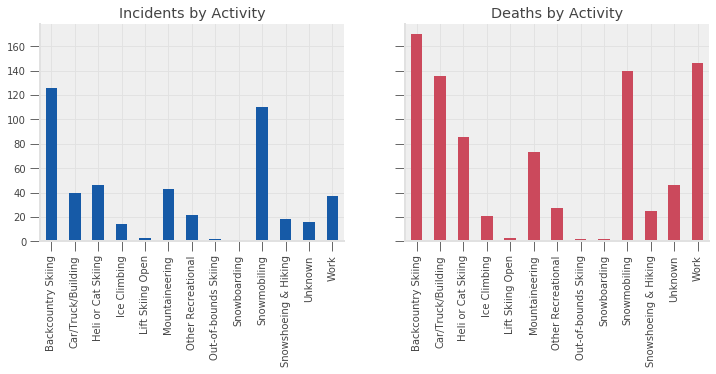

In [7]:
incidents.group_activity=incidents.group_activity.replace("Ski touring","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Out-of-Bounds Skiing","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Lift Skiing Closed","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Skiing","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Snowshoeing","Snowshoeing & Hiking")
incidents.group_activity=incidents.group_activity.replace("Snowshoeing and Hiking","Snowshoeing & Hiking")
incidents.group_activity=incidents.group_activity.replace("Mechanized Skiing","Heli or Cat Skiing")
incidents.group_activity=incidents.group_activity.replace("Heliskiing","Heli or Cat Skiing")
incidents.group_activity=incidents.group_activity.replace("At Outdoor Worksite","Work")
incidents.group_activity=incidents.group_activity.replace("Control Work","Work")
incidents.group_activity=incidents.group_activity.replace("Hunting/Fishing","Other Recreational")
incidents.group_activity=incidents.group_activity.replace("Inside Car/Truck on Road","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Car/Truck on Road","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Inside Building","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Outside Building","Car/Truck/Building")


incidents.group_activity.unique()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
incidents.groupby(['group_activity']).id.count().plot(kind='bar', title="Incidents by Activity", ax=ax[0])
incidents.groupby(['group_activity']).num_fatal.sum().plot(kind='bar', title="Deaths by Activity", ax=ax[1], color=colors[1])
ax[0].set_xlabel(None)
ax[1].set_xlabel(None);

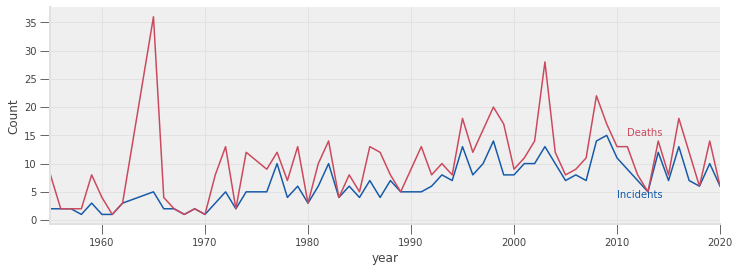

In [8]:
incidents["date"] = pd.to_datetime(incidents.ob_date)
incidents["year"] = incidents.date.apply(lambda x: x.year)
incidents.date = incidents.date.dt.date
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
f = incidents.groupby(["year"]).num_fatal.sum()
n = incidents.groupby(["year"]).id.count()
yearstart=1950
f=f[f.index>yearstart]
n=n[n.index>yearstart]
fig,ax = plt.subplots(1,1,figsize=(12,4))
n.plot(ax=ax)
f.plot(ax=ax)
ax.set_ylabel("Count")
ax.annotate("Incidents", (2010, 4), color=colors[0])
ax.annotate("Deaths", (2011, 15), color=colors[1]);

#### Mapping Incidents

Since the incident data includes coordinates, we might as well make a
map too. Unfortunately, some latitude and longitudes contain obvious errors.
Here, we try to fix them.

In [9]:
import re

# fix errors in latitude, longitude
latlon = incidents.location_coords
def makenumeric(cstr):
    if cstr is None:
        return([None,None])
    elif (type(cstr)==str):
        return([float(s) for s in re.findall(r'-?\d+\.?\d*',cstr)])
    else:
        return(cstr)

latlon = latlon.apply(makenumeric)

def good_lat(lat):
    return(lat >= 41.6 and lat <= 83.12) # min & max for Canada

def good_lon(lon):
    return(lon >= -141 and lon<= -52.6)

def fixlatlon(c):
    if (len(c)<2 or type(c[0])!=float or type(c[1])!=float):
        c = [None, None]
        return(c)
    lat = c[0]
    lon = c[1]
    if not good_lat(lat) and good_lat(lon):
        tmp = lat
        lat = lon
        lon = tmp
    if not good_lon(lon) and good_lon(-lon):
        lon = -lon
    if not good_lon(lon) and good_lon(lat):
        tmp = lat
        lat = lon
        lon = tmp
    if not good_lon(lon) and good_lon(-lat):
        tmp = -lat
        lat = lon
        lon = tmp
    if not good_lat(lat) or not good_lon(lon):
        c[0] = None
        c[1] = None
    else:
        c[0] = lat
        c[1] = lon
    return(c)

incidents["latlon"] = latlon.apply(fixlatlon)

In [10]:
def foo(c, a):
    if (type(a)==str):
        a = [float(s) for s in re.findall(r'-?\d+\.?\d*',a)]
    if len(a) <2:
        a = [None,None]
    return([a[1],a[0]] if type(c[0])!=float else c)
incidents["latlon_filled"]=[foo(c,a) for c,a in zip(incidents["latlon"],incidents["alt_coord"])]
nmiss = sum([a[0]==None for a in incidents.latlon_filled])
n = len(incidents.latlon_filled)
print("{} of {} incidents have latitude & longitude".format(n-nmiss, n))

317 of 478 incidents have latitude & longitude


In [11]:
# download forecast region definitions
# req = urllib.request.Request("https://www.avalanche.ca/api/forecasts")
# The above link doesn't work since COVID-19 lockdown. Currently we use an old cached version instead
#req = ("https://web.archive.org/web/20150319031605if_/http://www.avalanche.ca/api/forecasts")
#with urllib.request.urlopen(req) as response:
#    forecastregions = json.loads(response.read().decode('utf-8'))
req = "https://faculty.arts.ubc.ca/pschrimpf/forecast-regions2015.json"
with urllib.request.urlopen(req) as response:
    regions2015 = json.loads(response.read().decode('utf-8'))

req = "https://faculty.arts.ubc.ca/pschrimpf/forecast-regions2019.json"
with urllib.request.urlopen(req) as response:
    regions2019 = json.loads(response.read().decode('utf-8'))

forecastregions = regions2019
ids = [r['id'] for r in forecastregions['features']]
for r in regions2015['features'] :
     if not r['id'] in ids :
            forecastregions['features'].append(r)

You may have to uncomment the second line below if  folium is not installed.

In [12]:
# Map forecast regions and incidents
#!pip install --user folium
import folium
import matplotlib

cmap = matplotlib.cm.get_cmap('Set1')
fmap = folium.Map(location=[60, -98],
                            zoom_start=3,
                            tiles='Stamen Terrain')
with urllib.request.urlopen(req) as response:
    regions_tmp = json.loads(response.read().decode('utf-8'))
folium.GeoJson(regions_tmp,
               tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=[""]),
               highlight_function=lambda x: { 'weight': 10},
              style_function=lambda x: {'weight':1}).add_to(fmap)
activities = incidents.group_activity.unique()
for i in incidents.index:
    if incidents.latlon_filled[i][0] is not None and  incidents.latlon_filled[i][1] is not None:
        cindex=[j for j,x in enumerate(activities) if x==incidents.group_activity[i]][0]
        txt = "{}, {}<br>{} deaths"
        txt = txt.format(incidents.group_activity[i],
                        incidents.ob_date[i],
                        incidents.num_fatal[i]
                        )
        pop = folium.Popup(incidents.comment[i], parse_html=True, max_width=400)
        folium.CircleMarker(incidents.latlon_filled[i],
                      tooltip=txt,
                      popup=pop,
                      color=matplotlib.colors.to_hex(cmap(cindex)), fill=True, radius=5).add_to(fmap)
fmap

Take a moment to click around the map and read about some of the incidents.

Between presenting this information on a map and the list on [https://www.avalanche.ca/incidents/](https://www.avalanche.ca/incidents/) ,
which do you prefer and why?

#### Matching Incidents to Regions

Later, we will want to match incidents to forecasts, so let’s find the closest region to each incident.

Note that distance here will be in units of latitude, longitude (or
whatever coordinate system we use). At the equator, a distance of 1 is
approximately 60 nautical miles.

Since longitude lines get closer together farther from the equator,
these distances will be understated the further North you go.

This is not much of a problem if we’re just finding the
nearest region, but if we care about accurate distances, we should
re-project the latitude and longitude into a different coordinate system.

In [13]:
# Match incidents to nearest forecast regions.
from shapely.geometry import Point, Polygon, shape
point = Point(incidents.latlon_filled[0][1],incidents.latlon_filled[0][0])
def distances(latlon):
    point=Point(latlon[1],latlon[0])
    df = pd.DataFrame.from_dict([{'id':feature['id'],
                                  'distance':shape(feature['geometry']).distance(point)} for
                                 feature in forecastregions['features']])
    return(df)
def foo(x):
    if (x[0]==None):
        return(None)
    d = distances(x)
    return(d.id[d.distance.idxmin()])
incidents['nearest_region'] = incidents.latlon_filled.apply(foo)
incidents['nearest_distance'] = incidents.latlon_filled.apply(lambda x: None if x[0]==None else distances(x).distance.min())

In [14]:
incidents

,Unnamed: 0,avalanche_obs,comment,documents,...,latlon,latlon_filled,nearest_region,nearest_distance
0,0,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A snowshoer left on a solo hike March 14 and w...,[],...,"[49.488248, -123.205318]","[49.488248, -123.205318]",south-coast,0.000000
1,1,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",2 personnes sur 4 ont été complètement ensevel...,[],...,"[49.01584, -66.01389]","[49.01584, -66.01389]",chic-chocs,0.000000
2,2,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...",A snowmobiler was caught in an avalanche in st...,"[{'date': '2020-02-20', 'title': 'Annotated ov...",...,"[53.50768, -118.78414]","[53.50768, -118.78414]",north-rockies,0.290272
3,3,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...","Late in the afternoon on February 2, 2020 auth...","[{'date': '2020-02-12', 'title': 'RCMP Info Fe...",...,"[55.27017, -122.310302]","[55.27017, -122.310302]",north-rockies,0.000000
4,4,"[{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...",A party of three were skiing on a south-facing...,"[{'date': '2020-01-23', 'title': 'Upper slide ...",...,"[51.555461, -116.27115]","[51.555461, -116.27115]",banff-yoho-kootenay,0.000000
5,5,"[{'size': '2.5', 'type': 'S', 'trigger': 'Ma',...",Two people were snowmobiling on a small but st...,[],...,"[49.972113, -121.225966]","[49.972113, -121.225966]",south-coast-inland,0.000000
6,6,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A party of three snowboarders were climbing on...,[],...,"[59.702282, -136.602223]","[59.702282, -136.602223]",yukon,0.940686
7,7,"[{'size': '3.0', 'type': 'S', 'trigger': 'Sa',...",A party of three backcountry skiers were invol...,"[{'date': '2019-04-21', 'title': 'Parks Canada...",...,"[51.59123, -116.60428]","[51.59123, -116.60428]",little-yoho,0.000000
8,8,"[{'size': None, 'type': None, 'trigger': None,...",A party of three ice climbers were attempting ...,"[{'date': '2019-04-21', 'title': 'Howse Peak 2...",...,"[51.813002, -116.669218]","[51.813002, -116.669218]",banff-yoho-kootenay,0.087773
9,9,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...",A ski-tourer and split boarder triggered a per...,[],...,"[51.114536, -115.914762]","[51.114536, -115.914762]",banff-yoho-kootenay,0.000000


#### Forecast Data

We’ll now download all forecasts for all regions since November 2011 (roughly the earliest data available).

We can only request one forecast at a time, so this takes many hours to download.

To make this process run more quickly for readers, we ran the code ourselves and then stored the data in the cloud.

The function below will fetch all the forecasts from the cloud storage location and save them to a folder
named `avalanche_forecasts`.

In [15]:
def download_cached_forecasts():
    # download the zipped file and unzip it here
    url = "https://datascience.quantecon.org/assets/data/avalanche_forecasts.zip"
    with requests.get(url) as res:
        if not res.ok:
            raise ValueError("failed to download the cached forecasts")
        with zipfile.ZipFile(io.BytesIO(res.content)) as z:
            for f in z.namelist():
                if (os.path.isfile(f) and z.getinfo(f).file_size < os.stat(f).st_size):
                    warnings.warn(f"'File $f exists and is larger than version in cache. Not replacing.")
                else :
                    z.extract(f)

download_cached_forecasts()

The code below is what we initially ran to obtain all the forecasts.

You will notice that this code checks to see whether the files can be found in the `avalanche_forecasts`
directory (they can if you ran the `download_cached_forecasts` above!) and will only download them if they aren’t found.

You can experiment with this caching by deleting one or more files from the `avalanche_forecasts`
folder and re-running the cells below.

In [16]:
# Functions for downloading forecasts from Avalanche Canada

def get_forecast(date, region):
    url = "https://www.avalanche.ca/api/bulletin-archive/{}/{}.json".format(date.isoformat(),region)
    try:
        req = urllib.request.Request(url)
        with urllib.request.urlopen(req) as response:
            result = json.loads(response.read().decode('utf-8'))
        return(result)
    except:
        return(None)

def get_forecasts(start, end, region):
    day = start
    forecasts = []
    while(day<=end and day<end.today()):
        #print("working on {}, {}".format(region,day))
        forecasts = forecasts + [get_forecast(day, region)]
        #print("sleeping")
        time.sleep(0.1) # to avoid too much load on Avalanche Canada servers
        day = day + pd.Timedelta(1,"D")
    return(forecasts)

def get_season(year, region):
    start_month = 11
    start_day = 20
    last_month = 5
    last_day = 1
    if (not os.path.isdir("avalanche_forecasts")):
        os.mkdir("avalanche_forecasts")
    seasonfile = "avalanche_forecasts/{}_{}-{}.json".format(region, year, year+1)
    if (not os.path.isfile(seasonfile)):
        startdate = pd.to_datetime("{}-{}-{} 12:00".format(year, start_month, start_day))
        lastdate = pd.to_datetime("{}-{}-{} 12:00".format(year+1, last_month, last_day))
        season = get_forecasts(startdate,lastdate,region)
        with open(seasonfile, 'w') as outfile:
            json.dump(season, outfile, ensure_ascii=False)
    else:
        with open(seasonfile, "rb") as json_data:
            season = json.load(json_data)
    return(season)

In [17]:
forecastlist=[]

for year in range(2011,2019):
    print("working on {}".format(year))
    for region in [region["id"] for region in forecastregions["features"]]:
        forecastlist = forecastlist + get_season(year, region)

working on 2011


working on 2012


working on 2013


working on 2014


working on 2015


working on 2016


working on 2017


working on 2018


In [18]:
# convert to DataFrame and extract some variables
forecasts = pd.DataFrame.from_dict([f for f in forecastlist if not f==None],orient="columns")

forecasts["danger_date"] = forecasts.dangerRatings.apply(lambda r: r[0]["date"])
forecasts["danger_date"] = pd.to_datetime(forecasts.danger_date, utc=True).dt.date
forecasts["danger_alpine"]=forecasts.dangerRatings.apply(lambda r: r[0]["dangerRating"]["alp"])
forecasts["danger_treeline"]=forecasts.dangerRatings.apply(lambda r: r[0]["dangerRating"]["tln"])
forecasts["danger_belowtree"]=forecasts.dangerRatings.apply(lambda r: r[0]["dangerRating"]["btl"])

In [19]:
forecasts.head()

,avalancheSummary,bulletinTitle,confidence,dangerMode,...,danger_date,danger_alpine,danger_treeline,danger_belowtree
0,We have a few reports of glide crack releases ...,Avalanche Forecast - Northwest Coastal,Poor - Due to limited field observations,NaN,...,2011-11-21,2:Moderate,2:Moderate,1:Low
1,No new avalanches observed. We suspect that t...,Avalanche Forecast - Northwest Coastal,"Poor - Timing, track, or intensity of incomin...",NaN,...,2011-11-22,3:Considerable,3:Considerable,2:Moderate
2,"No recent avalanche have been reported, but I...",Avalanche Forecast - Northwest Coastal,Fair - Due to limited field observationsfor t...,NaN,...,2011-11-23,4:High,4:High,3:Considerable
3,"No recent avalanche have been reported, but I...",Avalanche Forecast - Northwest Coastal,Poor - Due to limited field observationsfor t...,NaN,...,2011-11-24,4:High,4:High,3:Considerable
4,"No recent avalanche have been reported, but I...",Avalanche Forecast - Northwest Coastal,Poor - Due to limited field observationsfor t...,NaN,...,2011-11-25,4:High,4:High,3:Considerable


In [20]:
# merge incidents to forecasts
adf = pd.merge(forecasts, incidents, how="left",
               left_on=["region","danger_date"],
               right_on=["nearest_region","date"],
              indicator=True)
adf["incident"] = adf._merge=="both"
print("There were {} incidents matched with forecasts data. These occured on {}% of day-regions with forecasts".format(adf.incident.sum(),adf.incident.mean()*100))

There were 39 incidents matched with forecasts data. These occured on 0.26666666666666666% of day-regions with forecasts


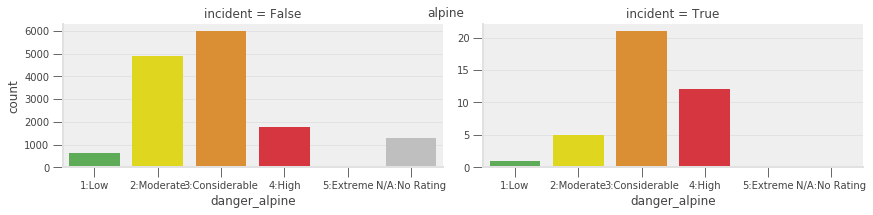

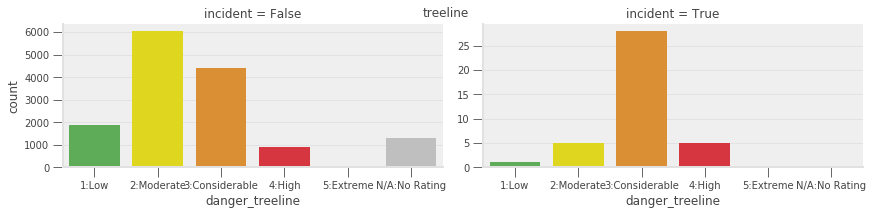

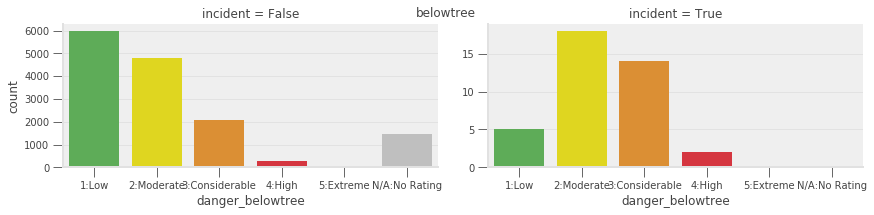

In [21]:
import seaborn as sns
ratings=sorted(adf.danger_alpine.unique())
ava_colors = ["#52BA4A", "#FFF300", "#F79218", "#EF1C29", "#1A1A1A", "#BFBFBF"]
for x in ["danger_alpine", "danger_treeline", "danger_belowtree"]:
    fig=sns.catplot(x=x, kind="count",col="incident", order=ratings, data=adf, sharey=False,
                    palette=ava_colors, height=3, aspect=2)
    plt.subplots_adjust(top=0.9)
    fig.fig.suptitle(x.replace("danger_",""))
    display(fig)

## Predicting Incidents from Text

### Preprocessing

The first step when using text as data is to pre-process the text.

In preprocessing, we will:

1. Clean: Remove unwanted punctuation and non-text characters.  
1. Tokenize: Break sentences down into words.  
1. Remove “stopwords”: Eliminate common words that actually provide no information, like “a” and “the”.  
1. Lemmatize words: Reduce words to their dictionary “lemma” e.g. “snowing” and “snowed” both become snow (verb).  

In [22]:
from bs4 import BeautifulSoup
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Remove stopwords (the, a, is, etc)
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=stopwords.union(set(string.punctuation))
# Lemmatize words e.g. snowed and snowing are both snow (verb)
wnl = nltk.WordNetLemmatizer()
def text_prep(txt):
    soup = BeautifulSoup(txt, "lxml")
    [s.extract() for s in soup('style')] # remove css
    txt=soup.text # remove html tags
    txt = txt.lower()
    tokens = [token for token in nltk.tokenize.word_tokenize(txt)]
    tokens = [token for token in tokens if not token in stopwords]
    #tokens = [token for token in tokens if not token ]
    tokens = [wnl.lemmatize(token) for token in tokens]
    if (len(tokens)==0):
        tokens = ["EMPTYSTRING"]
    return(tokens)

text_prep(forecasts.highlights[1000])

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['avalanche',
 'danger',
 'could',
 'spike',
 'high',
 'slope',
 'getting',
 'baked',
 'sun',
 'avoid',
 'traveling',
 'underneath',
 'area']

Now, let’s apply this to all avalanche summaries.

In [23]:
text_data = [text_prep(txt) for txt in adf.avalancheSummary]

Let’s make a bar plot of the most common words.

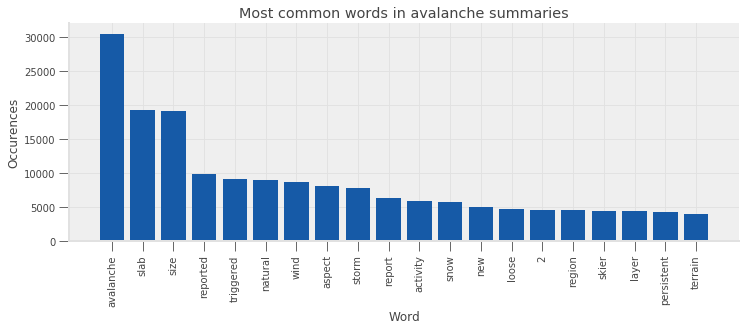

In [24]:
wf = nltk.FreqDist([word for doc in text_data for word in doc]).most_common(20)
words = [x[0] for x in wf]
cnt = [x[1] for x in wf]

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(len(words)), cnt);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Most common words in avalanche summaries');
ax.set_xlabel('Word');
ax.set_ylabel('Occurences');
plt.show()

### Feature Engineering

The “bag of words” approach is the simplest way to convert a collection of processed text
documents to a feature matrix. We view
each document as a bag of words, and our feature matrix
counts how many times each word appears. This method is called a “bag of words”
because we ignore the document’s word order.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
text_data = [text_prep(txt) for txt in adf.avalancheSummary]
y = adf.incident
X = vectorizer.fit_transform([' '.join(doc) for doc in text_data])

We can also perform more complicated feature engineering. One extension of the “bag of words” method
is to consider counts of pairs or triples of consecutive words. These
are called n-grams and can be created by setting the `n_gram`
argument to `CountVectorizer`. Another alternative might be to accommodate
the fact that common words will inherently have higher counts by using
term-frequency inverse-document-frequency (see below).

After creating our feature matrix, we can now apply any classification
method to predict incidents.

### Naive Bayes Classifier

A common text data classifier is the Naive Bayes classifier.
This classifier predicts incidents using Bayes’ rules.

$$
P(incident | words) = \frac{P(words|incident) P(incidents)}{P(words)}
$$

The classifier is naive, though; it assumes words are independent of one another in any given incident.

$$
P(words|incident) = \prod_{w \in words} P(w|incident)
$$

Although this assumption is implausible for text, the Naive Bayes
classifier can be computed extremely quickly, and sometimes quite well.

In [26]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=124)

In [27]:
from sklearn import naive_bayes
classifier = naive_bayes.MultinomialNB()
classifier.fit(Xtrain,ytrain)
np.mean(classifier.predict(Xtest)==ytest)

0.9931631722880584

In [28]:
from sklearn import metrics
print(metrics.confusion_matrix(ytest, classifier.predict(Xtest)))
print(metrics.classification_report(ytest, classifier.predict(Xtest)))

[[4357   19]
 [  11    1]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4376
        True       0.05      0.08      0.06        12

    accuracy                           0.99      4388
   macro avg       0.52      0.54      0.53      4388
weighted avg       0.99      0.99      0.99      4388



In [29]:
# print text with highest predicted probabilities
phat=classifier.predict_proba(X)[:,1]
def remove_html(txt):
    soup = BeautifulSoup(txt, "lxml")
    [s.extract() for s in soup('style')] # remove css
    return(soup.text)
docs = [remove_html(txt) for txt in adf.avalancheSummary]
txt_high = [(_,x) for _, x in sorted(zip(phat,docs), key=lambda pair: pair[0],reverse=True)]
txt_high[:10]

[(0.9996933795791444,
  "In the dogtooth backcountry, observers reported a size 2.5 avalanche with a crown 1m+ in depth, that was likely human triggered.  Remote triggering of avalanches continues to be reported from the region.  Explosive control work once again produced large avalanches to size 3.5 on all aspects with crowns ranging from 40 - 120 in depth.I've left the previous narratives in from earlier this because they help to illustrate the nature of the current hazard. From Thursday:  Lots of avalanche activity to report from the region.  In the north Moderate to Strong NW winds at ridge top continued to load lee slopes resulting in a natural avalanche cycle to size 2.5 with crown depths 20 - 60cm in depth.  Just south of Golden explosive control work produced spectacular results with avalanches to size 3.5 & crown depths 100 - 160cm in depth.  All aspects at & above treeline were involved with the majority of the failures occurring on the early Feb. surface hoar.  In the centra

In [30]:
# print text with lowest predicted probabilities
txt_low = [(_,x) for _, x in sorted(zip(phat,docs), key=lambda pair: pair[0])]
txt_low[:10]

[(2.3543721444156442e-20,
  'An early report from Wednesday includes a natural size 3 cornice triggered avalanche and a natural size 3 wet slab avalanche at 2200-2400 m elevation. On Tuesday, natural avalanche activity was reported in many parts of the region. Most of this activity was wet slabs up to size 3 and loose wet avalanches up to size 2 in response to the high elevation rain. A natural size 2.5 persistent slab avalanche was also observed on an east and southeast aspect slope at 2200 m in the area south of Nelson which failed on a layer down 50 cm. Ski cutting on Tuesday morning triggered several storm slab up to size 1.5 and explosives triggered numerous wet slab avalanches up to size 2.5 in the afternoon. On Thursday, if the sun comes out in full force, it will further destabilize an already warm snowpack. Natural loose wet and wet slab avalanches remain possible on steep sun exposed slopes. Large persistent slab avalanches also remain a serious concern until the snowpack has


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)


Predicting deaths from forecast text is very difficult because deaths
are so rare. A prediction exercise more likely to succeed would be to
predict the avalanche rating from the forecast text. However,
doing so is a very
artificial task, with little practical use.

Another alternative would be to gather more data on non-fatal
avalanches. Avalanche Canada also has user-submitted “Mountain
Information Network” reports. These reports include observations of
natural avalanches and information on non-fatal avalanche
incidents. Since the data is user-submitted, it is messy and more
difficult to work with. Nonetheless, working with it would be
good practice and could lead to some insights.

## Unsupervised Learning

The regression and classification methods that we have seen so far are
examples of supervised learning — we are trying to predict an observed outcome.
In unsupervised learning, we do not have an
observed outcome to predict. Instead, we try to find informative
patterns in the data. Unsupervised learning can be particularly useful
with text data. We will look at two related techniques for topic
modeling. These techniques attempt to extract distinct topics from a
collection of text documents.

### Latent Semantic Analysis

Latent semantic analysis is used by some search engines to rank
the similarities among documents. Latent semantic analysis begins with a
term document matrix, $ X $. The term document matrix is a number
of documents by number of terms matrix where the i,jth entry is the
measure of how often term j appears in document i. This could be the
same bag of words feature matrix we constructed above, or it could be
some other measure. For this example, we will use the term-frequency,
inverse-document-frequency representation.

$$
x^{tfidf}_{ij} = \frac{\text{occurences of term j in document
i}}{\text{length of document i}} \log \left(\frac{\text{number of
documents}}{\text{number of documents containing term j}}\right)
$$

Given a term document matrix, $ X $, latent semantic analysis
computes a lower rank approximation to $ X $ through the singular
value decomposition. This lower rank approximation can potentially be
interpreted or used instead of $ X $ for other learning
algorithms. In other contexts, similar decompositions are referred to
as principal components analysis or factor models.

In [31]:
# LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in text_data])

In [32]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=122, tol=0.0)

Here, we have computed a rank 10 approximation to the tf-idf matrix. We
can see how much variance of the original matrix that our 10
components reproduce. We can also look at how all terms in the
document contribute to each of the 10 components.

In [33]:
print(svd_model.explained_variance_ratio_)
print(svd_model.explained_variance_ratio_.cumsum())
terms = tfidf_vectorizer.get_feature_names()
comp_label=[]
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    message = ""
    for t in sorted_terms:
        message = message + "{:.2f} * {} + ".format(t[1],t[0])
    print(message)
    comp_label.append(message)

[0.01381632 0.03554643 0.03357845 0.01686496 0.01410331 0.01372541
 0.01263702 0.01076714 0.01056195 0.00848458]
[0.01381632 0.04936276 0.08294121 0.09980617 0.11390948 0.12763489
 0.14027191 0.15103905 0.161601   0.17008558]
Topic 0: 
0.38 * avalanche + 0.27 * size + 0.26 * slab + 0.25 * reported + 0.21 * new + 0.18 * triggered + 0.17 * wind + 
Topic 1: 
0.69 * new + 0.38 * reported + 0.24 * avalanche + 0.11 * observation + 0.10 * activity + 0.09 * observed + 0.09 * region + 
Topic 2: 
1.00 * emptystring + 0.00 * new + 0.00 * reported + 0.00 * avalanche + 0.00 * observation + 0.00 * recent + 0.00 * region + 
Topic 3: 
0.43 * recent + 0.41 * observation + 0.25 * please + 0.25 * information + 0.25 * mountain + 0.22 * network + 0.18 * region + 
Topic 4: 
0.43 * reported + 0.40 * recent + 0.21 * loose + 0.16 * wet + 0.13 * avalanche + 0.12 * steep + 0.10 * solar + 
Topic 5: 
0.39 * loose + 0.32 * wet + 0.28 * observed + 0.27 * steep + 0.22 * terrain + 0.17 * solar + 0.15 * dry + 
Topic 6:

Finally, we can attempt to visualize the components.

The LSA reduced the dimensionality of the representation of documents
from thousands (of term-frequency inverse-document-frequency) to ten
components. While ten is more manageable than thousands, it is still too
many dimensions to effectively visualize. t-SNE is a technique to further
reduce dimensionality. t-SNE is a nonlinear data transformation
from many dimensions to 2, while attempting to preserve the
original clustering of their original domain. In other words, if a
set of documents are closely clustered in the 10 dimensional
LSA space, then they will also be close together in the 2 dimensional
t-SNE representation.

In [34]:
lsa_topic_matrix = svd_model.transform(X)

In [35]:
from sklearn.manifold import TSNE
nplot = 2000 # reduce the size of the data to speed computation and make the plot less cluttered
lsa_topic_sample = lsa_topic_matrix[np.random.choice(lsa_topic_matrix.shape[0], nplot, replace=False)]
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=500,
                      n_iter=1000, verbose=10, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_sample)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...


[t-SNE] Computed neighbors for 2000 samples in 0.139s...


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.179s


[t-SNE] Iteration 50: error = 71.8229904, gradient norm = 0.2115118 (50 iterations in 0.747s)


[t-SNE] Iteration 100: error = 71.0676804, gradient norm = 0.2109433 (50 iterations in 0.698s)


[t-SNE] Iteration 150: error = 71.0986404, gradient norm = 0.2117732 (50 iterations in 0.666s)


[t-SNE] Iteration 200: error = 71.5289993, gradient norm = 0.2101949 (50 iterations in 0.728s)


[t-SNE] Iteration 250: error = 71.2274246, gradient norm = 0.2104338 (50 iterations in 0.743s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.227425


[t-SNE] Iteration 300: error = 1.4611626, gradient norm = 0.0008886 (50 iterations in 0.565s)


[t-SNE] Iteration 350: error = 1.3849361, gradient norm = 0.0003756 (50 iterations in 0.518s)


[t-SNE] Iteration 400: error = 1.3619086, gradient norm = 0.0003433 (50 iterations in 0.511s)


[t-SNE] Iteration 450: error = 1.3510504, gradient norm = 0.0003208 (50 iterations in 0.510s)


[t-SNE] Iteration 500: error = 1.3444470, gradient norm = 0.0002569 (50 iterations in 0.503s)


[t-SNE] Iteration 550: error = 1.3402228, gradient norm = 0.0002145 (50 iterations in 0.501s)


[t-SNE] Iteration 600: error = 1.3370047, gradient norm = 0.0001720 (50 iterations in 0.502s)


[t-SNE] Iteration 650: error = 1.3329822, gradient norm = 0.0002176 (50 iterations in 0.504s)


[t-SNE] Iteration 700: error = 1.3298432, gradient norm = 0.0001803 (50 iterations in 0.506s)


[t-SNE] Iteration 750: error = 1.3282200, gradient norm = 0.0001632 (50 iterations in 0.514s)


[t-SNE] Iteration 800: error = 1.3251215, gradient norm = 0.0001925 (50 iterations in 0.520s)


[t-SNE] Iteration 850: error = 1.3236896, gradient norm = 0.0001995 (50 iterations in 0.519s)


[t-SNE] Iteration 900: error = 1.3221409, gradient norm = 0.0001572 (50 iterations in 0.521s)


[t-SNE] Iteration 950: error = 1.3210713, gradient norm = 0.0001530 (50 iterations in 0.522s)


[t-SNE] Iteration 1000: error = 1.3188227, gradient norm = 0.0001924 (50 iterations in 0.521s)
[t-SNE] KL divergence after 1000 iterations: 1.318823


The t-SNE model creates a
non-linear projection from our 10 dimensional LSA topics onto two dimensional space.
It can be useful for visualizing high-dimensional data. One word of caution:
the output of the t-SNE model can depend on the parameters of the
algorithm. Failure to see clear clusters in the t-SNE visualization
could mean either the original data was not clustered in higher
dimensional space or that the t-SNE algorithm parameters were
chosen poorly.

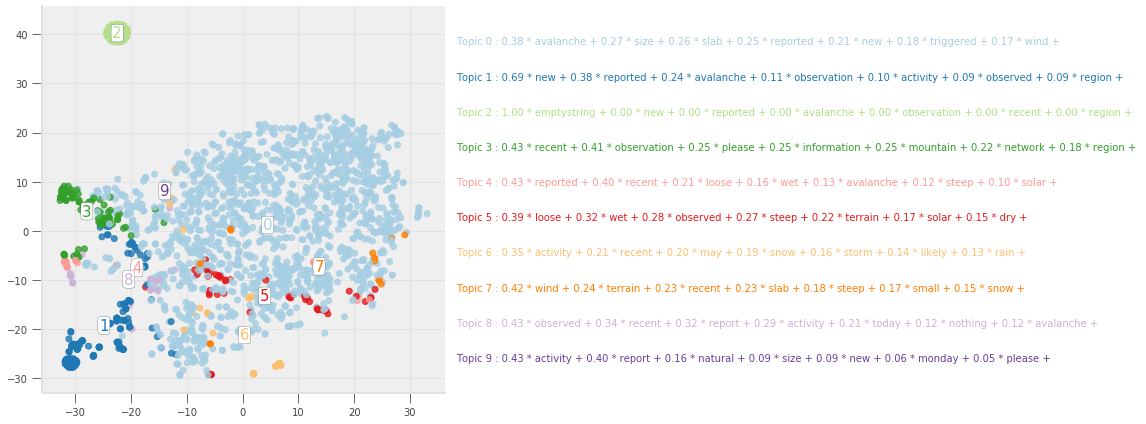

In [36]:
cmap = matplotlib.cm.get_cmap('Paired')
fig, ax = plt.subplots(1,2,figsize=(16,6))
n_topics=len(svd_model.components_)
lsa_keys = np.argmax(lsa_topic_sample, axis=1)
ax[0].scatter(x=tsne_lsa_vectors[:,0],y=tsne_lsa_vectors[:,1], color=[cmap(i) for i in lsa_keys], alpha=0.8)
bbox_props = dict(boxstyle="round4,pad=0.1", lw=0.2, fc="white")
for i in range(n_topics):
    m = tsne_lsa_vectors[lsa_keys==i, :].mean(axis=0)
    ax[0].text(m[0], m[1], str(i), ha="center", va="center",
               size=15, color=cmap(i),
               bbox=bbox_props)
    ax[1].text(0,1-(i+1)*1/(n_topics+1),"Topic " + str(i) + " : "+ comp_label[i],ha="left", va="center", color=cmap(i))
    ax[1].axis('off')
fig.tight_layout()

From this plot, we can immediately see two things. First, most documents
are closest to topic 0. Second, most topics are not
well-separated.


<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)

### Latent Dirichlet Analysis

Latent dirichlet analysis (LDA) produces similar outputs as latent semantic
analysis, but LDA often produces nicer results. The statistical theory
underlying LSA is built on continuous $ X $ features. LDA uses
similar ideas, but takes into account that text is discrete.

In [37]:
# LDA
import gensim
# gensim works with a list of lists of tokens
text_data = [text_prep(txt) for txt in forecasts.avalancheSummary]

In [38]:
# convert to bag of words
dictionary = gensim.corpora.Dictionary(text_data)
bow_data = [dictionary.doc2bow(text) for text in text_data]

In [39]:
ldamodel = gensim.models.ldamodel.LdaModel(bow_data, num_topics = 5, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.075*"avalanche" + 0.036*"new" + 0.033*"activity" + 0.025*"reported" + 0.023*"slab" + 0.022*"wind" + 0.020*"may" + 0.018*"storm" + 0.018*"snow" + 0.014*"region"')
(1, '0.052*"avalanche" + 0.051*"size" + 0.045*"slab" + 0.030*"triggered" + 0.021*"aspect" + 0.018*"storm" + 0.018*"natural" + 0.017*"persistent" + 0.015*"reported" + 0.014*"layer"')
(2, '0.064*"avalanche" + 0.039*"min" + 0.031*"observation" + 0.026*"report" + 0.026*"mountain" + 0.024*"new" + 0.023*"information" + 0.021*"region" + 0.020*"reported" + 0.018*"see"')
(3, '0.045*"avalanche" + 0.039*"snow" + 0.029*"storm" + 0.020*"layer" + 0.019*"likely" + 0.018*"rise" + 0.018*"problem" + 0.016*"slab" + 0.016*"weak" + 0.014*"danger"')
(4, '0.046*"avalanche" + 0.045*"loose" + 0.045*"slab" + 0.042*"size" + 0.027*"steep" + 0.027*"wind" + 0.025*"terrain" + 0.025*"wet" + 0.022*"aspect" + 0.021*"small"')


In [40]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, bow_data, dictionary)
lda_display

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.166606 -0.013611       1        1  48.162643
4     -0.210665 -0.034335       2        1  20.452095
0     -0.005692  0.033086       3        1  16.753466
2      0.214831 -0.252915       4        1   8.310365
3      0.168132  0.267776       5        1   6.321429, topic_info=     Category          Freq         Term         Total  loglift  logprob
23    Default  30485.000000    avalanche  30485.000000  30.0000  30.0000
108   Default   5117.000000        loose   5117.000000  29.0000  29.0000
17    Default  18145.000000         size  18145.000000  28.0000  28.0000
51    Default   5386.000000         snow   5386.000000  27.0000  27.0000
26    Default   5382.000000          new   5382.000000  26.0000  26.0000
30    Default   8020.000000        storm   8020.000000  25.0000  25.0000
133   Default   4751.000000        layer   4751.000000  24.0000  24.0000
67    Default   3598.000000        steep   3598.000000  23.0000  23.0000
3838  Default   1807.000000          min   1807.000000  22.0000  22.0000
101   Default   8217.000000       aspect   8217.000000  21.0000  21.0000
...       ...           ...          ...           ...      ...      ...
34     Topic5    281.708527           's   1164.264160   1.3423  -4.8175
229    Topic5    292.514587         last   1370.320557   1.2169  -4.7799
14     Topic5    495.270874       report   6451.359375   0.1943  -4.2533
681    Topic5    222.696915         high    683.254333   1.6402  -5.0526
18     Topic5    561.292297         slab  19714.970703  -0.7977  -4.1281
255    Topic5    226.791183        still    861.706421   1.4263  -5.0344
54     Topic5    281.811951  observation   2644.830078   0.5221  -4.8171
83     Topic5    252.295303         area   3230.909180   0.2113  -4.9278
68     Topic5    223.265594      terrain   3966.997803  -0.1162  -5.0500
22     Topic5    230.527298         wind   9018.587891  -0.9054  -5.0180

[356 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1327      3  0.991410     'm
882       4  0.991109    're
34        1  0.308349     's
34        2  0.003436     's
34        3  0.317797     's
34        4  0.128837     's
34        5  0.242213     's
91        1  0.486699      1
91        2  0.513299      1
299       1  0.556985    1.5
...     ...       ...    ...
195       2  0.818539    wet
195       3  0.181142    wet
22        1  0.403389   wind
22        2  0.342515   wind
22        3  0.228639   wind
22        5  0.025614   wind
123       1  0.999098   work
1355      5  0.993914  worth
1326      5  0.995554   year
2464      5  0.991398      ’

[543 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])


<a id='exercise-2'></a>
> See exercise 3 in the [*exercise list*](#exerciselist-0)



<a id='exercise-3'></a>
> See exercise 4 in the [*exercise list*](#exerciselist-0)

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Use another classification method to predict incidents. Check whether
your method outperforms the Naive Bayes classifier.

([*back to text*](#exercise-0))

**Exercise 2**

Apply LSA to the weather or snowpack descriptions. Can you notice
any patterns?

([*back to text*](#exercise-1))

**Exercise 3**

Apply LDA to the weather or snowpack descriptions. Can you notice
any patterns?

([*back to text*](#exercise-2))

**Exercise 4**

Use the reduced rank representation of text from LSA or LDA as a
feature matrix to predict avalanche incidents. Compare the
performance with the bag of words feature matrix.

([*back to text*](#exercise-3))